In [122]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

1. Read the data into df 

In [125]:
df = pd.read_csv("clean_data.csv")

In [127]:
df.columns

Index(['sample_date_time', 'local_authority_name', 'year', 'grand_total',
       'Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH',
       'industry_percentage', 'minerals_percentage', 'residential_percentage',
       'transport_percentage', 'agriculture_percentage'],
      dtype='object')

In [129]:
df.head

<bound method NDFrame.head of           sample_date_time      local_authority_name  year  grand_total  \
0      2018-01-02 09:03:00            Northumberland  2018     507736.4   
1      2018-01-02 09:38:00                St. Helens  2018      13635.7   
2      2018-01-03 09:53:00  East Riding of Yorkshire  2018     249425.3   
3      2018-01-03 10:23:00  East Riding of Yorkshire  2018     249425.3   
4      2018-01-03 10:56:00  East Riding of Yorkshire  2018     249425.3   
...                    ...                       ...   ...          ...   
16389  2022-12-22 10:02:00                St. Helens  2022      13636.0   
16390  2022-12-22 13:34:00    North Northamptonshire  2022      98659.0   
16391  2022-12-22 13:39:00    North Northamptonshire  2022      98659.0   
16392  2022-12-22 13:49:00    North Northamptonshire  2022      98659.0   
16393  2022-12-28 11:47:00                Harborough  2022      59269.0   

       Ammonia(N)  BOD ATU  Nitrate-N  Sld Sus@105C    pH  \
0       

2. Create integer time columns so we can feed into the model as an input

In [132]:
# Ensure the column is in datetime format
df['sample_date_time'] = pd.to_datetime(df['sample_date_time'])

# Extract multiple features from the datetime column
#df[['year', 'month', 'day', 'hour']] = df['sample_date_time'].apply(lambda x: pd.Series([x.year, x.month, x.day, x.hour]))

#print(df)

In [134]:
#define the numeric columns 
numeric_cols = ['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH',
       'industry_percentage', 'minerals_percentage', 'residential_percentage',
       'transport_percentage', 'agriculture_percentage']

In [136]:
numeric_cols = df.select_dtypes(include='number').columns
#remove outliers using iqr
Q1 = df[numeric_cols].quantile(0.25) 
Q3 = df[numeric_cols].quantile(0.75) 
IQR = Q3 - Q1                        
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:\n", Q1, "\nQ3:\n", Q3, "\nIQR:\n", IQR)
print("\nLower Bound:\n", lower_bound, "\nUpper Bound:\n", upper_bound)
df_no_outliers = df[
    ((df[numeric_cols] >= lower_bound) & (df[numeric_cols] <= upper_bound)).all(axis=1)
]

print("\nOriginal DataFrame:")
print(df)

print("\nDataFrame without Outliers:")
print(df_no_outliers)
print(f"Original shape: {df.shape}, New shape: {df_no_outliers.shape}")

Q1:
 year                       2019.000000
grand_total               18063.000000
Ammonia(N)                    0.030000
BOD ATU                       1.100000
Nitrate-N                     2.200000
Sld Sus@105C                  4.800000
pH                            7.670000
industry_percentage           0.153469
minerals_percentage           0.000000
residential_percentage        0.662453
transport_percentage          3.604748
agriculture_percentage       42.917123
Name: 0.25, dtype: float64 
Q3:
 year                       2021.000000
grand_total               92002.000000
Ammonia(N)                    0.160000
BOD ATU                       2.700000
Nitrate-N                     8.330000
Sld Sus@105C                 15.000000
pH                            8.090000
industry_percentage           0.749987
minerals_percentage           0.066407
residential_percentage        2.515791
transport_percentage          6.307951
agriculture_percentage       70.354779
Name: 0.75, dtype: float64

In [138]:
df_no_outliers.describe()

,sample_date_time,year,grand_total,Ammonia(N),BOD ATU,Nitrate-N,Sld Sus@105C,pH,industry_percentage,minerals_percentage,residential_percentage,transport_percentage,agriculture_percentage
count,9230,9230.000000,9230.000000,9230.000000,9230.000000,9230.000000,9230.000000,9230.000000,9230.000000,9230.000000,9230.000000,9230.000000,9230.000000
mean,2020-10-05 01:25:39.406283776,2020.228602,60540.399458,0.074770,1.648463,5.678359,8.762924,7.913131,0.367354,0.028096,1.358209,4.493899,62.338718
min,2018-01-04 10:49:00,2018.000000,7670.000000,0.002000,1.000000,0.004000,1.800000,7.040000,0.020670,0.000000,0.150873,1.484548,22.911328
25%,2019-08-28 10:02:15,2019.000000,27904.000000,0.030000,1.000000,2.280000,4.370000,7.740000,0.112877,0.000000,0.681963,3.372316,55.206669
50%,2020-10-15 12:59:00,2020.000000,57866.000000,0.042000,1.400000,5.450000,6.900000,7.940000,0.220599,0.010224,1.142014,4.193754,67.316544
75%,2021-11-04 10:06:45,2021.000000,90162.000000,0.090000,1.940000,8.190000,11.000000,8.100000,0.569219,0.032253,1.553047,5.210044,70.354779
max,2022-12-28 11:47:00,2022.000000,176677.000000,0.355000,5.100000,17.300000,30.000000,8.710000,1.395117,0.162540,4.878567,9.496732,85.709580
std,NaN,1.266848,36153.079163,0.070589,0.755091,3.914112,5.966328,0.283665,0.325028,0.038677,1.031663,1.697941,14.951972


In [140]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error


3. Define the inputs and outputs of the model and split test and train

In [143]:
df_no_outliers.head()

,sample_date_time,local_authority_name,year,grand_total,Ammonia(N),BOD ATU,Nitrate-N,Sld Sus@105C,pH,industry_percentage,minerals_percentage,residential_percentage,transport_percentage,agriculture_percentage
9,2018-01-04 10:49:00,Cheshire West and Chester,2018,94115.2,0.060,1.00,1.67,13.5,7.22,0.797746,0.029220,1.106304,4.439772,67.316544
13,2018-01-05 12:05:00,Cheshire East,2018,116629.7,0.264,2.21,5.41,23.1,7.96,0.138215,0.004544,1.095862,4.094412,70.949338
14,2018-01-05 12:39:00,Craven,2018,117872.5,0.065,1.21,1.82,22.3,7.87,0.035632,0.069652,0.180449,1.494326,42.556915
17,2018-01-09 10:12:00,Pendle,2018,16937.7,0.068,1.28,1.82,3.0,8.09,0.378446,0.000000,1.441164,3.840545,58.412299
18,2018-01-09 10:33:00,Burnley,2018,11068.2,0.040,1.00,1.06,3.0,8.12,0.084928,0.068665,2.078025,5.553749,34.519615


In [145]:
# define input features (X) and target variables (y)
X = df_no_outliers[[ 'industry_percentage', 'minerals_percentage', 'residential_percentage',
        'transport_percentage', 'agriculture_percentage']]

y = df_no_outliers[['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH']]

# split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


4. Train the model

In [148]:
# initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=15, learning_rate=0.01)

# wrap it in MultiOutputRegressor to handle multiple targets
multi_output_model = MultiOutputRegressor(xgb_model)

# train the model
multi_output_model.fit(X_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

5. Predict using test data

In [150]:
# predict on test data
y_pred = multi_output_model.predict(X_test)

# convert predictions to DataFrame (optional)
y_pred_df = pd.DataFrame(y_pred, columns=['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH'])

print(y_pred_df.head())  # show some predictions


   Ammonia(N)   BOD ATU  Nitrate-N  Sld Sus@105C        pH
0    0.079798  1.902513   3.797052      7.274201  7.976204
1    0.108903  1.444326   5.367748      7.776315  7.936071
2    0.042650  1.521365   1.250452      5.604966  7.776025
3    0.055205  1.451492   6.414273     10.642296  8.015191
4    0.042650  1.521365   1.250452      5.604966  7.776025


6. Evaluate model using MSE 

In [152]:
# compute MSE for each target variable
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# print the MSE for each predicted target
for i, col in enumerate(y.columns):
    print(f"MSE for {col}: {mse[i]:.4f}")


MSE for Ammonia(N): 0.0038
MSE for BOD ATU: 0.4773
MSE for Nitrate-N: 8.4086
MSE for Sld Sus@105C: 31.4149
MSE for pH: 0.0584


7. Evaluate model using R2


In [154]:
from sklearn.metrics import r2_score
# get predictions
y_pred = multi_output_model.predict(X_test)

# compute R² score for each target
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')

# print R² scores
for i, col in enumerate(y.columns):
    print(f"R² for {col}: {r2_scores[i]:.4f}")


R² for Ammonia(N): 0.2032
R² for BOD ATU: 0.1416
R² for Nitrate-N: 0.4637
R² for Sld Sus@105C: 0.0919
R² for pH: 0.2487


In [175]:
#hyperparamter experimenting and tuning below 
from sklearn.model_selection import GridSearchCV
X = df_no_outliers[[ 
    'industry_percentage', 'minerals_percentage', 'residential_percentage',
    'transport_percentage', 'agriculture_percentage'
]]

y = df_no_outliers['Nitrate-N']  # tuning for ONE target here

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.02, 0.04, 0.08, 0.16],
    'subsample': [0.1, 0.3, 0.5, 0.7, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',  # or use 'neg_mean_squared_error'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))



Fitting 3 folds for each of 625 candidates, totalling 1875 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}
R² Score: 0.46387251691235354
MSE: 8.405979172211985


In [177]:
#hyperparamter experimenting and tuning below 
from sklearn.model_selection import GridSearchCV
X = df_no_outliers[[ 
    'industry_percentage', 'minerals_percentage', 'residential_percentage',
    'transport_percentage', 'agriculture_percentage'
]]

y = df_no_outliers['Ammonia(N)']  # tuning for ONE target here

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',  # or use 'neg_mean_squared_error'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))



Fitting 3 folds for each of 625 candidates, totalling 1875 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
R² Score: 0.21318346370401642
MSE: 0.0037646882639551797


In [179]:
#hyperparamter experimenting and tuning below 
from sklearn.model_selection import GridSearchCV
X = df_no_outliers[[ 
    'industry_percentage', 'minerals_percentage', 'residential_percentage',
    'transport_percentage', 'agriculture_percentage'
]]

y = df_no_outliers['BOD ATU']  # tuning for ONE target here

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',  # or use 'neg_mean_squared_error'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))



Fitting 3 folds for each of 625 candidates, totalling 1875 fits
Best Hyperparameters: {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
R² Score: 0.1506313922317537
MSE: 0.4723282143920804


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [180]:
#hyperparamter experimenting and tuning below 
from sklearn.model_selection import GridSearchCV
X = df_no_outliers[[ 
    'industry_percentage', 'minerals_percentage', 'residential_percentage',
    'transport_percentage', 'agriculture_percentage'
]]

y = df_no_outliers['Sld Sus@105C']  # tuning for ONE target here

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',  # or use 'neg_mean_squared_error'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))



Fitting 3 folds for each of 625 candidates, totalling 1875 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
R² Score: 0.11222576502046688
MSE: 30.71321958311737


In [181]:
#hyperparamter experimenting and tuning below 
from sklearn.model_selection import GridSearchCV
X = df_no_outliers[[ 
    'industry_percentage', 'minerals_percentage', 'residential_percentage',
    'transport_percentage', 'agriculture_percentage'
]]

y = df_no_outliers['pH']  # tuning for ONE target here

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',  # or use 'neg_mean_squared_error'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))



Fitting 3 folds for each of 625 candidates, totalling 1875 fits
Best Hyperparameters: {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
R² Score: 0.25626070611400464
MSE: 0.057799905856186204


## Ensemble Stacking 

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb


In [208]:
# Features and one target (e.g. 'Nitrate-N')
X = df_no_outliers[['industry_percentage', 'minerals_percentage', 'residential_percentage',
                    'transport_percentage', 'agriculture_percentage']]
y = df_no_outliers['Sld Sus@105C']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Base models
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=6, learning_rate=0.1)
model_rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
model_gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)

# Fit each model on the training data
model_xgb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
# Get predictions from base models
pred_xgb = model_xgb.predict(X_test)
pred_rf = model_rf.predict(X_test)
pred_gb = model_gb.predict(X_test)

# Stack predictions horizontally to create new feature set
stacked_preds = np.column_stack((pred_xgb, pred_rf, pred_gb))
# Meta-model (simple Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_preds, y_test)

# Final stacked prediction
final_pred = meta_model.predict(stacked_preds)


In [209]:
print("Stacked Model Performance:")
print(f"R² Score: {r2_score(y_test, final_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, final_pred):.4f}")


Stacked Model Performance:
R² Score: 0.1137
MSE: 30.6621


15. Try creating every possible different ratio and using as input

In [213]:
df_no_outliers['industry_to_minerals'] = df_no_outliers['industry_percentage'] / (df_no_outliers['minerals_percentage'] + 0.001)
df_no_outliers['industry_to_residential'] = df_no_outliers['industry_percentage'] / df_no_outliers['residential_percentage']
df_no_outliers['industry_to_transport'] = df_no_outliers['industry_percentage'] / df_no_outliers['transport_percentage']
df_no_outliers['industry_to_agriculture'] = df_no_outliers['industry_percentage'] / df_no_outliers['agriculture_percentage']
df_no_outliers['minerals_to_residential'] = df_no_outliers['minerals_percentage'] / df_no_outliers['residential_percentage']
df_no_outliers['minerals_to_transport'] = df_no_outliers['minerals_percentage'] / df_no_outliers['transport_percentage']
df_no_outliers['minerals_to_agriculture'] = df_no_outliers['minerals_percentage'] / df_no_outliers['agriculture_percentage']
df_no_outliers['residential_to_transport'] = df_no_outliers['residential_percentage'] / df_no_outliers['transport_percentage']
df_no_outliers['residential_to_agriculture'] = df_no_outliers['residential_percentage'] / df_no_outliers['agriculture_percentage']
df_no_outliers['transport_to_agriculture'] = df_no_outliers['transport_percentage'] / df_no_outliers['agriculture_percentage']

/var/folders/jp/lg_9lz6n3pl67xbgkk8bw9qh0000gn/T/ipykernel_56310/1214204783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['industry_to_minerals'] = df_no_outliers['industry_percentage'] / (df_no_outliers['minerals_percentage'] + 0.001)
/var/folders/jp/lg_9lz6n3pl67xbgkk8bw9qh0000gn/T/ipykernel_56310/1214204783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['industry_to_residential'] = df_no_outliers['industry_percentage'] / df_no_outliers['residential_percentage']
/v

In [215]:
# Define input features (X) and target variables (y)
X = df_no_outliers[[ 'industry_to_minerals', 'industry_to_residential', 'industry_to_transport', 'industry_to_agriculture', 'minerals_to_residential', 'minerals_to_transport', 'minerals_to_agriculture', 'residential_to_transport', 'residential_to_agriculture', 'transport_to_agriculture' ]]

y = df_no_outliers[['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH']]


# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [217]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler to scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [219]:
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=15, learning_rate=0.01)

# Wrap it in MultiOutputRegressor to handle multiple targets
multi_output_model = MultiOutputRegressor(xgb_model)

# Train the model
multi_output_model.fit(X_train_scaled, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [220]:
# Predict on test data
y_pred = multi_output_model.predict(X_test)

# Convert predictions to DataFrame (optional)
y_pred_df = pd.DataFrame(y_pred, columns=['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH'])

print(y_pred_df.head())  # Show some predictions


   Ammonia(N)   BOD ATU  Nitrate-N  Sld Sus@105C        pH
0    0.084435  1.579002   5.222020      9.965025  7.821142
1    0.092029  1.543203   5.222020      8.807167  7.821227
2    0.084409  1.631631   5.222129      9.965025  7.837966
3    0.092052  1.561940   5.143122      8.807167  7.821429
4    0.084409  1.631631   5.222129      9.965025  7.837966


16. Evaluate with input ratios

In [222]:
# Compute MSE for each target variable
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Print the MSE for each predicted target
for i, col in enumerate(y.columns):
    print(f"MSE for {col}: {mse[i]:.4f}")
 

MSE for Ammonia(N): 0.0050
MSE for BOD ATU: 0.5594
MSE for Nitrate-N: 23.6859
MSE for Sld Sus@105C: 35.5818
MSE for pH: 0.0850


In [226]:
from sklearn.metrics import r2_score
# Get predictions
y_pred = multi_output_model.predict(X_test)

# Compute R² score for each target
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')

# Print R² scores
for i, col in enumerate(y.columns):
    print(f"R² for {col}: {r2_scores[i]:.4f}")


R² for Ammonia(N): -0.0455
R² for BOD ATU: -0.0059
R² for Nitrate-N: -0.5107
R² for Sld Sus@105C: -0.0285
R² for pH: -0.0932


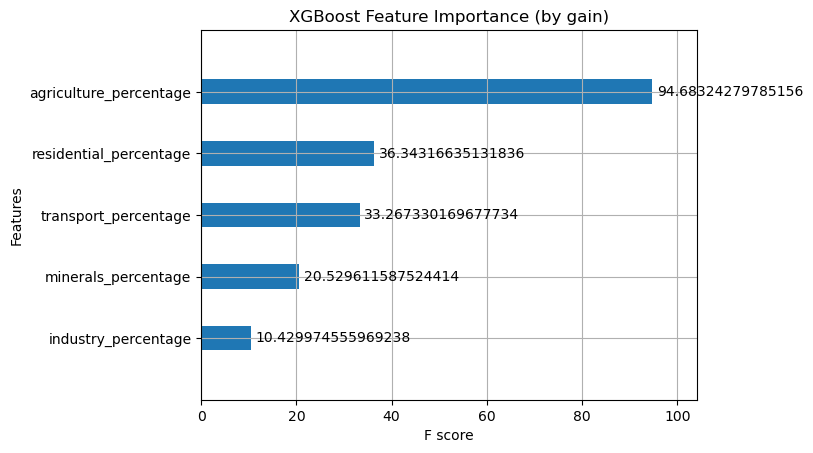

In [230]:
# Plot feature importance
xgb.plot_importance(model_xgb, importance_type='gain', height=0.4)
plt.title('XGBoost Feature Importance (by gain)')
plt.show()
